# Fisherfaces Robustness


In [ ]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from vic.dataloader import (
    load_orl,
    load_yale,
    make_fixed_test_indices,
    split_with_fixed_test,
)
from vic.models import Fisherfaces
from vic.transform import transform_test_set


In [2]:
SEED = 0
N_TEST = 3
N_TRAIN = 7
RUNS = 20

fisherfaces_kwargs = {
    "strict": False,
    "normalize": False,
    "random_state": SEED,
}

orl = load_orl("../data/ORL")
yale = load_yale("../data/Yale")

test_idx_orl, pool_idx_orl = make_fixed_test_indices(orl, n_test=N_TEST, seed=SEED)
test_idx_yale, pool_idx_yale = make_fixed_test_indices(yale, n_test=N_TEST, seed=SEED)


In [3]:
def make_fisherfaces():
    return Fisherfaces(**fisherfaces_kwargs)


def build_transform_kwargs(operation, param):
    if operation == "blur":
        return {"blur_std": float(param)}
    if operation == "noise":
        return {"noise_std": float(param)}
    if operation in ("rotation", "rotate"):
        return {"angle": float(param)}
    if operation == "brightness":
        return {"brightness_factor": float(param)}
    if operation == "flip":
        direction = "" if param == "none" else str(param)
        return {"flip_direction": direction}
    raise ValueError(f"Unsupported operation: {operation}")


def run_experiment(
    data,
    test_idx,
    pool_idx,
    operation,
    params,
    *,
    runs=RUNS,
    n_train=N_TRAIN,
    seed_master=SEED,
    json_file=None,
):
    cache = {}
    log_path = Path(json_file) if json_file else None

    if log_path and log_path.exists():
        with log_path.open("r", encoding="utf-8") as f:
            cache = json.load(f)

    master_rng = np.random.default_rng(seed_master)
    acc_all = []

    for param in params:
        acc_runs = []

        for _ in range(runs):
            split_seed = int(master_rng.integers(0, 1_000_000))
            key = f"{operation}_{param}_{split_seed}"

            if key in cache:
                acc = float(cache[key])
            else:
                np.random.seed(split_seed)
                op_name = "rotate" if operation == "rotation" else operation
                transformed_data, transformed_test_idx = transform_test_set(
                    data,
                    test_idx,
                    operation=op_name,
                    replace=True,
                    **build_transform_kwargs(operation, param),
                )

                Xtr, ytr, Xte, yte = split_with_fixed_test(
                    transformed_data,
                    transformed_test_idx,
                    pool_idx,
                    n_train=n_train,
                    seed=split_seed,
                )

                model = make_fisherfaces()
                model.fit(Xtr, ytr)
                y_pred = model.predict(Xte)
                acc = float(np.mean(y_pred == yte))

                if log_path:
                    cache[key] = acc
                    log_path.parent.mkdir(parents=True, exist_ok=True)
                    with log_path.open("w", encoding="utf-8") as f:
                        json.dump(cache, f, indent=2)

            acc_runs.append(acc)

        acc_all.append(acc_runs)

    acc_all = np.asarray(acc_all, dtype=np.float64)
    mean = acc_all.mean(axis=1)
    std = acc_all.std(axis=1)
    ci95 = 1.96 * std / np.sqrt(runs)
    return mean, std, ci95


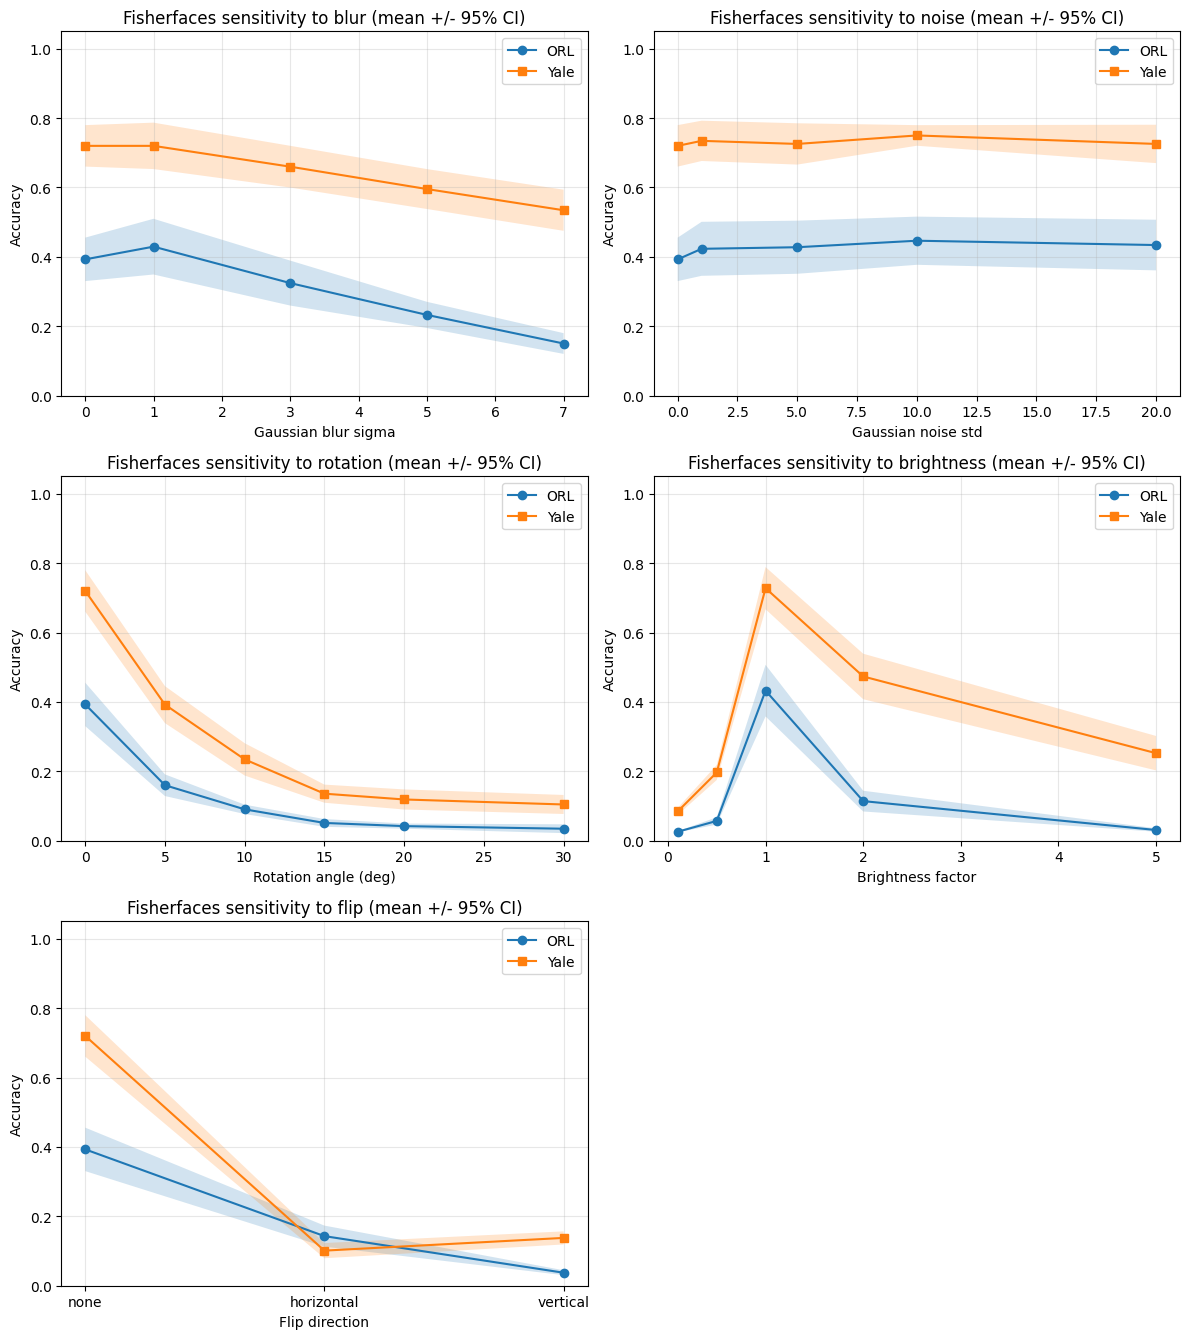

In [ ]:
effects = {
    "blur": ("Gaussian blur sigma", [0, 1, 3, 5, 7]),
    "noise": ("Gaussian noise std", [0, 1, 5, 10, 20]),
    "rotation": ("Rotation angle (deg)", [0, 5, 10, 15, 20, 30]),
    "brightness": ("Brightness factor", [0.1, 0.5, 1.0, 2.0, 5.0]),
    "flip": ("Flip direction", ["none", "horizontal", "vertical"]),
}

n_cols = 2
n_rows = int(np.ceil(len(effects) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4.5 * n_rows))
axes = axes.flatten()

for i, (effect_key, (xlabel, params)) in enumerate(effects.items()):
    ax = axes[i]

    mean_orl, std_orl, ci_orl = run_experiment(
        orl,
        test_idx_orl,
        pool_idx_orl,
        effect_key,
        params,
        json_file=f"../logs/Fisherfaces_Robustness_ORL_{effect_key}.json",
    )

    mean_yale, std_yale, ci_yale = run_experiment(
        yale,
        test_idx_yale,
        pool_idx_yale,
        effect_key,
        params,
        json_file=f"../logs/Fisherfaces_Robustness_Yale_{effect_key}.json",
    )

    if all(isinstance(p, (int, float, np.integer, np.floating)) for p in params):
        x_vals = np.asarray(params, dtype=float)
        x_tick_labels = None
    else:
        x_vals = np.arange(len(params), dtype=float)
        x_tick_labels = params

    ax.plot(x_vals, mean_orl, marker="o", label="ORL")
    ax.fill_between(x_vals, mean_orl - ci_orl, mean_orl + ci_orl, alpha=0.2)

    ax.plot(x_vals, mean_yale, marker="s", label="Yale")
    ax.fill_between(x_vals, mean_yale - ci_yale, mean_yale + ci_yale, alpha=0.2)

    if x_tick_labels is not None:
        ax.set_xticks(x_vals)
        ax.set_xticklabels(x_tick_labels)

    ax.set_title(f"Fisherfaces sensitivity to {effect_key}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend()

for j in range(len(effects), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("../figures/Fisherfaces_robustness.png", dpi=300)
plt.show()
